<a href="https://colab.research.google.com/github/osjayaprakash/deeplearning/blob/main/CS_230_Full_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
root_dir = kagglehub.dataset_download("shahrukhkhan/im2latex100k")
# path = kagglehub.dataset_download("gregoryeritsyan/im2latex-230k")

print("Path to dataset files:", root_dir)

Path to dataset files: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7


In [3]:
!pip install tensorflow

In [135]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, GRU, Embedding, Bidirectional,
                                     TimeDistributed, Concatenate, RepeatVector, LSTM)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Initialize Tokenizer (Configure it with LaTeX vocabulary)
vocab_size = 600  # Adjust based on your dataset
tokenizer = Tokenizer(num_words=vocab_size, filters='', lower=False)

def fit_tokenizer(texts):
    """Fit the tokenizer on the LaTeX text corpus."""
    tokenizer.fit_on_texts(texts)

def text_to_sequence(text):
    """Convert LaTeX text to a sequence of tokens."""
    return tokenizer.texts_to_sequences([text])[0]

def sequence_to_text(sequence):
    """Convert token sequence back to LaTeX text."""
    return tokenizer.sequences_to_texts([sequence])[0]

In [10]:
print(dir(tokenizer))
print(text_to_sequence("a+b"))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api_export_path', '_api_export_symbol_id', 'analyzer', 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'get_config', 'index_docs', 'index_word', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 'sequences_to_texts', 'sequences_to_texts_generator', 'split', 'texts_to_matrix', 'texts_to_sequences', 'texts_to_sequences_generator', 'to_json', 'word_counts', 'word_docs', 'word_index']
[]


# Preprocess

In [11]:
def preprocess_image(image):
    """Preprocess the input image: Resize and normalize."""
    image = tf.image.resize(image, (50, 200))  # Resize to (50, 200)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_and_preprocess_images(image_paths):
    """Load and preprocess a batch of images."""
    images = [preprocess_image(tf.io.decode_image(tf.io.read_file(path), channels=1))
              for path in image_paths]
    return tf.stack(images)

def prepare_sequences(latex_texts, max_seq_length):
    """Convert LaTeX texts to padded sequences of tokens."""
    sequences = [text_to_sequence(text) for text in latex_texts]
    return pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [154]:
IMG_WIDTH, IMG_HEIGHT = 200, 50
EMBEDDING_DIM = 256
MAX_SEQ_LENGTH = 100  # Max length of output sequence

from tensorflow import keras
from tensorflow.keras.layers import Layer

class CastingLayer(Layer):
    def __init__(self, **kwargs):
        super(CastingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, dtype=tf.float32)

def create_cnn_encoder():
    """Create the CNN feature extractor."""
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))  # Grayscale input
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(EMBEDDING_DIM, activation='relu')(x)
    return Model(inputs, cnn_output)

def create_model():
    """Create the encoder-decoder model."""
    cnn_encoder = create_cnn_encoder()

    # Encoder
    image_input = cnn_encoder.input
    image_output = cnn_encoder.output
    encoder_output = RepeatVector(MAX_SEQ_LENGTH, name='enc_output')(image_output)

    # Decoder
    text_input = Input(shape=(MAX_SEQ_LENGTH,), name="text_input")
    text_embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH)(text_input)

    merged_input = tf.keras.layers.Concatenate()([encoder_output, text_embedding])

    lstm_output = LSTM(vocab_size, return_sequences=True)(merged_input)
    #output = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_output)

    # #decoder_gru = Bidirectional(GRU(256, return_sequences=True), name='dec_gru')(decoder_embedding)
    # decoder_gru = GRU(256, return_sequences=True, name='gru')(decoder_embedding)
    # decoder_gru = TimeDistributed(Dense(EMBEDDING_DIM), name='td_gru')(decoder_gru) # Added a Dense layer to match encoder output dimension

    # # Concatenate Encoder and Decoder
    # decoder_concat = Concatenate()([encoder_output, decoder_gru])
    # # Modified: Wrap the Dense layer in a lambda layer to handle the mask
    # dense_layer = Dense(vocab_size, activation='softmax')
    # decoder_output = TimeDistributed(dense_layer)(decoder_concat)

    # Full Model
    model = Model([image_input, text_input], lstm_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45            │ (None, 50, 200, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 50, 200, 32)    │            320 │ input_layer_45[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_69          │ (None, 25, 100, 32)    │              0 │ conv2d_74[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 25, 100, 64)    │         18,496 │ max_pooling2d_69[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_70          │ (None, 12, 50, 64)     │              0 │ conv2d_75[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 12, 50, 128)    │         73,856 │ max_pooling2d_70[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_71          │ (None, 6, 25, 128)     │              0 │ conv2d_76[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_23 (Flatten)      │ (None, 19200)          │              0 │ max_pooling2d_71[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 256)            │      4,915,456 │ flatten_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_output (RepeatVector) │ (None, 100, 256)       │              0 │ dense_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_23 (Embedding)  │ (None, 100, 256)       │        153,600 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_32            │ (None, 100, 512)       │              0 │ enc_output[0][0],      │
│ (Concatenate)             │                        │                │ embedding_23[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 100, 600)       │      2,671,200 │ concatenate_32[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,832,928 (29.88 MB)

 Trainable params: 7,832,928 (29.88 MB)

 Non-trainable params: 0 (0.00 B)

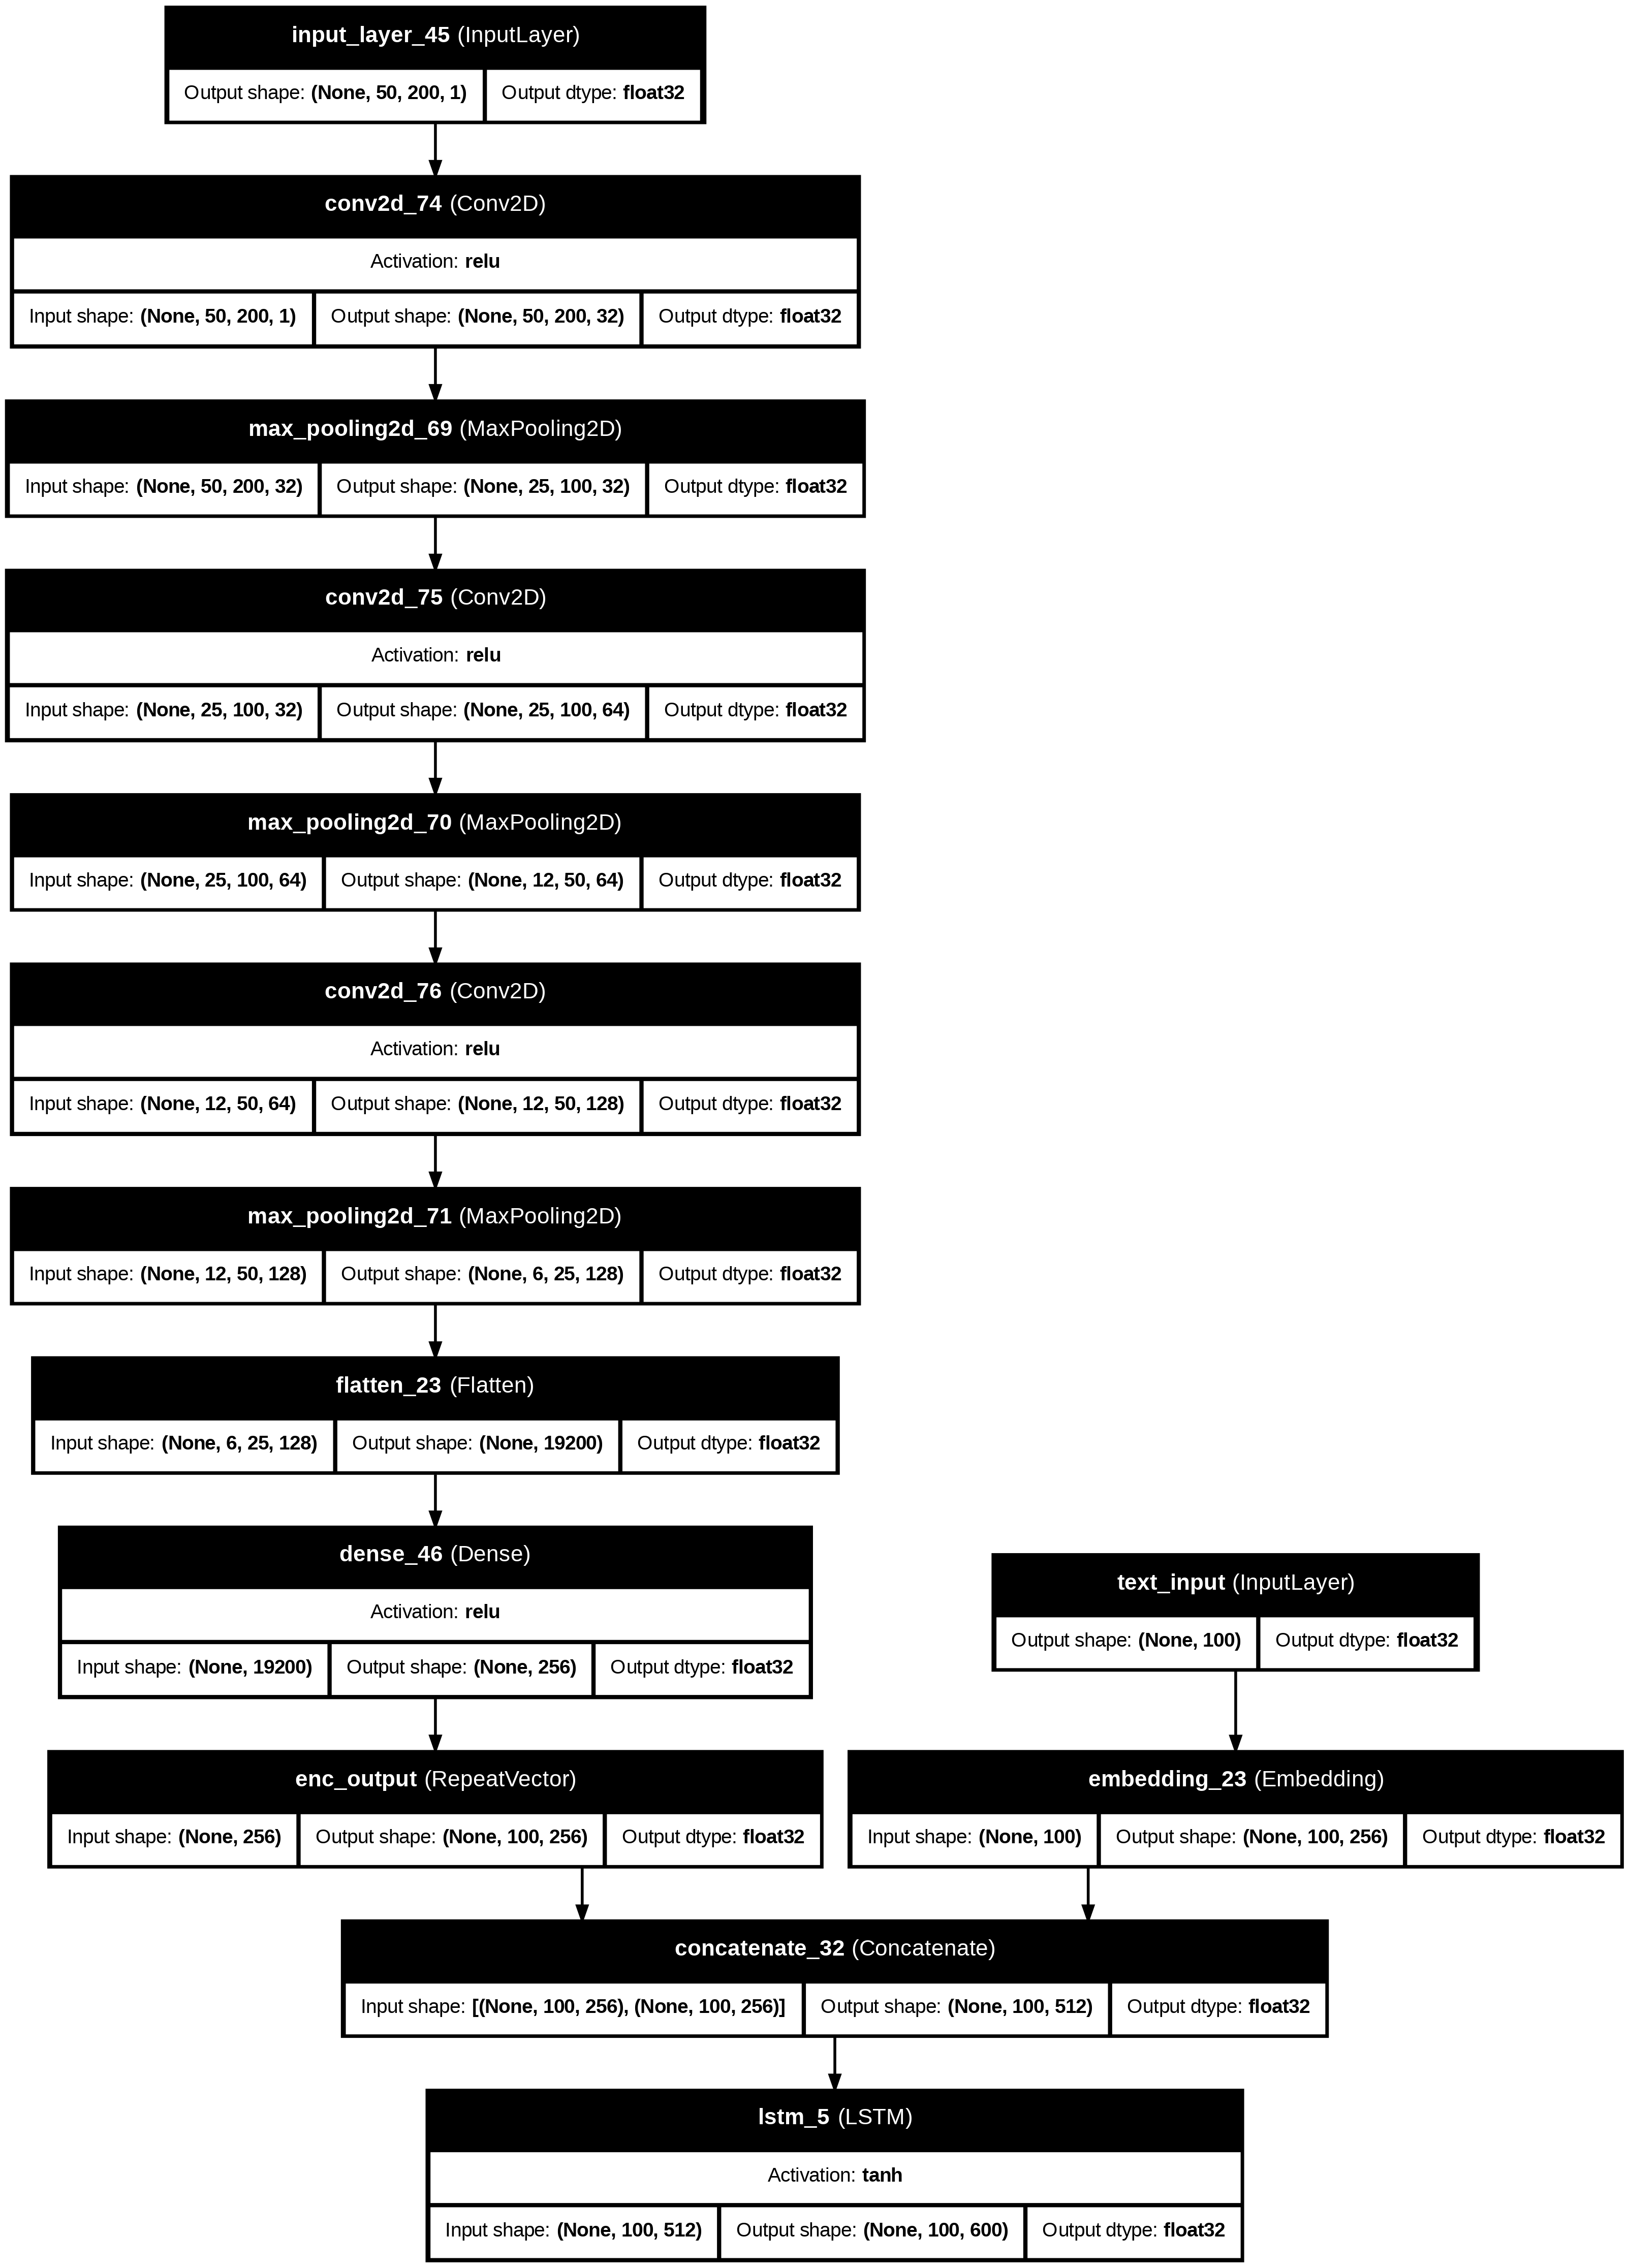

In [155]:
#dot_img_file =
import keras
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_dtype=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       )

In [156]:
import pandas as pd

df = pd.read_csv(f"{root_dir}/im2latex_train.csv", nrows=1000)

train_image_paths = []
train_latex_texts = []

for index, row in df.iterrows():
    train_image_paths += [f"{root_dir}//formula_images_processed/formula_images_processed/{row.image}"]
    train_latex_texts += [row.formula]

tf.experimental.numpy.experimental_enable_numpy_behavior()
train_images = load_and_preprocess_images(train_image_paths)
train_images = train_images.astype(np.float32)

fit_tokenizer(train_latex_texts)

train_sequences = prepare_sequences(train_latex_texts, MAX_SEQ_LENGTH)
train_sequences = np.expand_dims(train_sequences, -1)
train_sequences = train_sequences.astype(np.int32)

In [157]:
print(train_sequences.shape, train_images.shape)
print(type(train_sequences))
print(train_sequences[0].reshape(1,-1).tolist()[0])
print(sequence_to_text(train_sequences[0].reshape(1,-1).tolist()[0]))

(1000, 100, 1) (1000, 50, 200, 1)
<class 'numpy.ndarray'>
[177, 62, 3, 1, 48, 1, 78, 94, 26, 71, 2, 2, 199, 85, 3, 1, 18, 149, 15, 2, 177, 1, 96, 2, 3, 1, 18, 2, 1, 13, 1, 6, 10, 17, 7, 4, 1, 18, 2, 2, 1, 5, 4, 1, 5, 18, 10, 9, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }


In [158]:
print(train_image_paths[0])
!ls -lart "{train_image_paths[0]}"
print(train_latex_texts[0])

/root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7//formula_images_processed/formula_images_processed/66667cee5b.png
-rw-r--r-- 1 root root 5350 Oct 26 18:29 /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7//formula_images_processed/formula_images_processed/66667cee5b.png
\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }


In [ ]:
# Train the model
tf.get_logger().setLevel('INFO')
tf.debugging.disable_traceback_filtering()

assert len(tokenizer.word_index) + 1

model.fit([train_images, train_sequences], train_sequences,
          epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.2409 - loss: 6.3423 - val_accuracy: 0.4534 - val_loss: 4.0790
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4413 - loss: 3.8265 - val_accuracy: 0.5436 - val_loss: 3.0265
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5795 - loss: 2.9540 - val_accuracy: 0.4930 - val_loss: 3.4890
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5890 - loss: 3.0966 - val_accuracy: 0.7819 - val_loss: 2.1508
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7883 - loss: 1.9121 - val_accuracy: 0.8111 - val_loss: 1.3811
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8072 - loss: 1.3818 - val_accuracy: 0.8186 - val_loss: 1.2945
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8106 - loss: 1.2946 - val_accuracy: 0.8176 - val_loss: 1.2584
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.8097 - loss: 1.3039 - val_accuracy: 0.8207 - val_loss:

In [115]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = layers.Input(shape=(10, 128, 128, 3), batch_size=32)
conv_2d_layer = layers.Conv2D(64, (3, 3))
print(inputs.shape)
#print(conv_2d_layer(inputs).shape)
outputs = layers.TimeDistributed(conv_2d_layer)(inputs)
print(outputs.shape)

(32, 10, 128, 128, 3)
(32, 10, 126, 126, 64)
